In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json, math

In [32]:
models = [
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoLarge_OctreeNCA2DSegmentation/", "OctreeL"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/peso_med_OctreeNCA2DSegmentation/", "MedNCA"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/cholec_OctreeNCASegmentation", "OctreeNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/cholecfFixAbl_none_10_1.0_16_1_1.0_0.99_OctreeNCASegmentation", "OctreeNCA"),

    #("/local/scratch/clmn1/octree_study_new/Experiments/cholec_UNet_efficientnet-b0_0_MinUNetSegmentation/", "UNet Efficientnet"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/cholec_UNet_mobilenet_v2_0_MinUNetSegmentation/", "UNet Mobilenetv2"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/cholec_UNet_resnet18_0_MinUNetSegmentation/", "UNet Resnet18"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/cholec_UNet_vgg11_0_MinUNetSegmentation/", "UNet VGG11"),

    ("/local/scratch/clmn1/octree_study_new/Experiments/cholec_unet_UNetSegmentation/", "UNet"),#UNet3D
    ("/local/scratch/clmn1/octree_study_new/Experiments/cholec_munet3d_UNet_resnet18_0_minUNet3DSegmentation/", "Resnet18"),#UNet3D Resnet18
    ("/local/scratch/clmn1/octree_study_new/Experiments/cholec_munet3d_UNet_densenet121_0_minUNet3DSegmentation/", "Densenet"),#UNet3D Densenet121
    ("/local/scratch/clmn1/octree_study_new/Experiments/cholec_M3dSegmentation/", "M3D-NCA"),
]

In [33]:
nan_template = pd.read_csv(f"/local/scratch/clmn1/octree_study_new/Experiments/cholec_sam_Sam3DSegmentation/eval/standard.csv", sep='\t')
nan_template.set_index('Unnamed: 0', inplace=True)
annnotation_list = []
annotation_dict = {}
all_files = []
for i, (model, model_name) in enumerate(models):
    score = pd.read_csv(f"{model}/eval/standard.csv", sep='\t')
    score.set_index('Unnamed: 0', inplace=True)
    score[nan_template.isna()] = np.nan
    
    MEAN_DICE = True
    if MEAN_DICE:
        score = score.loc[:, ["DiceScore/0", "DiceScore/1", "DiceScore/2", "DiceScore/3", "DiceScore/4"]]
        score = score.mean(axis=1)
        score = score.mean() * 100
    else:
        score = score.loc[:, "DiceScore/0"].mean() * 100
        


    mem_allocation = json.load(open(f"{model}/mem_allocation.json"))["byte"]
    num_params = json.load(open(f"{model}/num_params.json"))["num_params"]

    eval_file = {}

    eval_file["model"] = model
    eval_file["mem_allocation"] = mem_allocation
    eval_file["num_params"] = num_params
    eval_file["score"] = score
    df = pd.DataFrame(index=[i], data=eval_file)
    all_files.append(df)
    annnotation_list.append((num_params, score, model_name))
    annotation_dict[model_name] = (num_params, score)

all_files = pd.concat(all_files)

In [34]:
from IPython.display import display, HTML
display(HTML(all_files.to_html()))

,model,mem_allocation,num_params,score
0,/local/scratch/clmn1/octree_study_new/Experiments/cholecfFixAbl_none_10_1.0_16_1_1.0_0.99_OctreeNCASegmentation,2590576640,16960,64.010676
1,/local/scratch/clmn1/octree_study_new/Experiments/cholec_unet_UNetSegmentation/,14993841152,19073285,53.126643
2,/local/scratch/clmn1/octree_study_new/Experiments/cholec_munet3d_UNet_resnet18_0_minUNet3DSegmentation/,17270131712,42656757,61.896950
3,/local/scratch/clmn1/octree_study_new/Experiments/cholec_munet3d_UNet_densenet121_0_minUNet3DSegmentation/,24096355328,31245621,63.332436
4,/local/scratch/clmn1/octree_study_new/Experiments/cholec_M3dSegmentation/,14314118656,12480,64.030185


In [35]:
#sam_path = "/local/scratch/clmn1/octree_study_new/Experiments/cholec_sam_Sam3DSegmentation"
sam_path = "/local/scratch/clmn1/octree_study_dev/Experiments/cholec_sam2_base_plus_Sam3DSegmentation"

sam_performance = pd.read_csv(f"{sam_path}/eval/standard.csv", sep='\t')

sam_performance = sam_performance.loc[:, ["DiceScore/0", "DiceScore/1", "DiceScore/2", "DiceScore/3", "DiceScore/4"]]
sam_performance = sam_performance.mean(axis=1)
sam_performance = sam_performance.mean() * 100
print(sam_performance)

sam_num_params = json.load(open(f"{sam_path}/num_params.json"))["num_params"]
annotation_dict["SAM2"] = (sam_num_params, sam_performance)

60.066187474544996


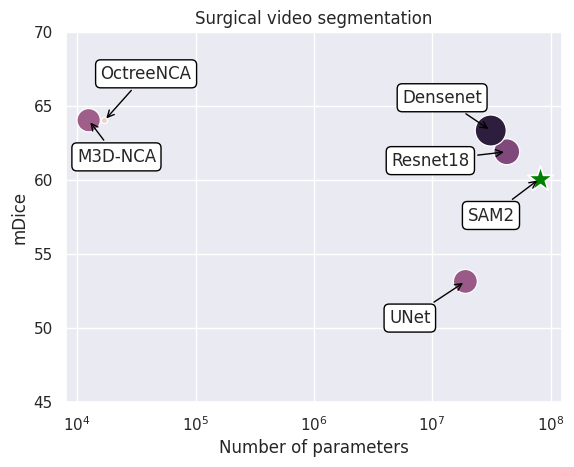

In [36]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="mem_allocation",legend=False, sizes=(20, 500))

#ax.annotate('SAM2', (sam_num_params, sam_performance), textcoords="offset points", xytext=(0,10), ha='center',
#    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
#    arrowprops=dict(arrowstyle="->"))
scatter = ax.scatter(sam_num_params, sam_performance, color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)

#for x,y,txt in annnotation_list:
#    ax.annotate(txt, (x,y), textcoords="offset points", xytext=(0,10), ha='center',
#        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
#        arrowprops=dict(arrowstyle="->"))
#    pass

def my_annotate(name, xytext):
    ax.annotate(name, annotation_dict[name], textcoords="offset points", xytext=xytext, ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        arrowprops=dict(arrowstyle="->", color='black'))

my_annotate("M3D-NCA", (20,-30))
my_annotate("OctreeNCA", (30,30))
my_annotate("UNet", (-40,-30))
my_annotate("SAM2", (-35,-30))
my_annotate("Densenet", (-35, 20))
my_annotate("Resnet18", (-55,-10))

plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("mDice")
plt.title("Surgical video segmentation")
plt.ylim(45, 70)
plt.savefig("figures/cholec_video_segmentation.pdf", bbox_inches='tight')

In [37]:
min_vram = math.floor(10 * all_files["mem_allocation"].min() / 1024**3) / 10
max_vram = math.ceil(10 * all_files["mem_allocation"].max() / 1024**3) / 10


def compute_circle_size(mem_allocation):
    mem_allocation = mem_allocation / 1024**3
    return 20 + 480 * (mem_allocation - min_vram) / (max_vram - min_vram)

In [38]:
all_files.loc[:, "circle_size"] = all_files["mem_allocation"].apply(compute_circle_size)

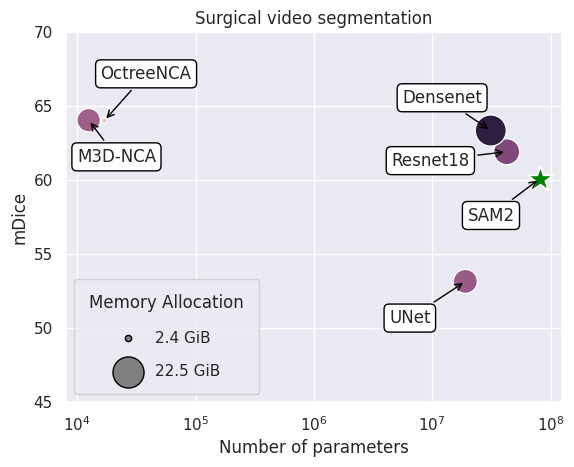

In [39]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="circle_size",legend=False, sizes=(20, 500))
scatter = ax.scatter(sam_num_params, sam_performance, color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)


def my_annotate(name, xytext):
    ax.annotate(name, annotation_dict[name], textcoords="offset points", xytext=xytext, ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        arrowprops=dict(arrowstyle="->", color='black'))

my_annotate("M3D-NCA", (20,-30))
my_annotate("OctreeNCA", (30,30))
my_annotate("UNet", (-40,-30))
my_annotate("SAM2", (-35,-30))
my_annotate("Densenet", (-35, 20))
my_annotate("Resnet18", (-55,-10))

size_values = [20, 500]
size_labels = [f"{min_vram} GiB", f"{max_vram} GiB"]
handles = [
    plt.scatter([], [], s=size, edgecolor="black", color="grey", label=label)
    for size, label in zip(size_values, size_labels)  # Adjust sizes to match your plot
]
# Add the custom legend
plt.legend(
    handles=handles,
    title="Memory Allocation",
    labelspacing=1.2,
    loc="lower left",
    borderpad=1.0,
    frameon=True
)

plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("mDice")
plt.title("Surgical video segmentation")
plt.ylim(45, 70)
plt.savefig("figures/cholec_video_segmentation.pdf", bbox_inches='tight')